In [109]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [7]:
P_data1 = pd.read_csv('data/total_precipitation/precip_2000_2011.csv')
P_data2 = pd.read_csv('data/total_precipitation/precip_2012_2023.csv')
P_data = pd.concat([P_data1, P_data2])
P_data.head()

,date,lat,lon,tp
0,2000-01-01,55.25,4.75,0.003465
1,2000-01-01,55.25,5.25,0.003525
2,2000-01-01,55.25,5.75,0.003562
3,2000-01-01,55.25,6.25,0.003803
4,2000-01-01,55.25,6.75,0.004075


In [8]:
P_data['lon'].unique()

array([ 4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,
        9.25,  9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25,
       13.75, 14.25, 14.75, 15.25])

In [6]:
P_data['lat'].unique()

array([55.25, 54.75, 54.25, 53.75, 53.25, 52.75, 52.25, 51.75, 51.25,
       50.75, 50.25, 49.75, 49.25, 48.75, 48.25, 47.75, 47.25, 46.75,
       46.25, 45.75, 45.25, 44.75])

In [135]:
lat = 53.25
lon = 10.25
P_sample = P_data[(P_data['lon'] == lon) & (P_data['lat'] == lat)]
P_sample['date'] = pd.to_datetime(P_sample['date'])
P_sample.set_index('date', inplace=True)
P_sample['rolling_std_month'] = P_sample['tp'].rolling(window=30).std()
P_sample['rolling_std_year'] = P_sample['tp'].rolling(window=365).std()

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_21740\475892272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_sample['date'] = pd.to_datetime(P_sample['date'])
C:\Users\Nutzer\AppData\Local\Temp\ipykernel_21740\475892272.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_sample['rolling_std_month'] = P_sample['tp'].rolling(window=30).std()
C:\Users\Nutzer\AppData\Local\Temp\ipykernel_21740\475892272.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

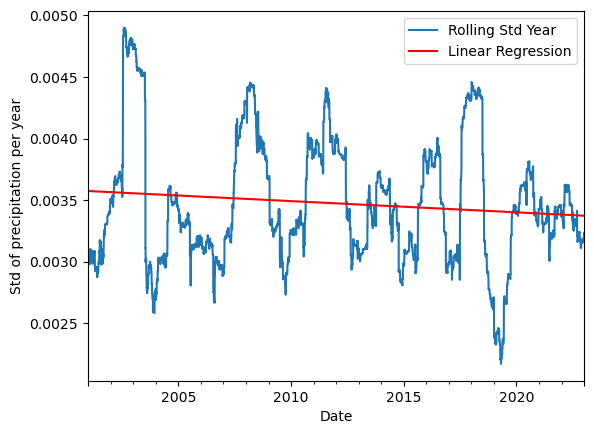

In [95]:
P_sample_clean = P_sample.dropna(subset=['rolling_std_year'])

# Fit a linear regression line
x = np.array(range(len(P_sample_clean.index)))
y = P_sample_clean['rolling_std_year'].values
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

# Plot the data and the regression line
P_sample_clean['rolling_std_year'].plot(label='Rolling Std Year')
plt.plot(P_sample_clean.index, polynomial(x), color='red', label='Linear Regression')
plt.xlabel('Date')
plt.ylabel('Std of precipitation per year')
plt.legend()
plt.show()

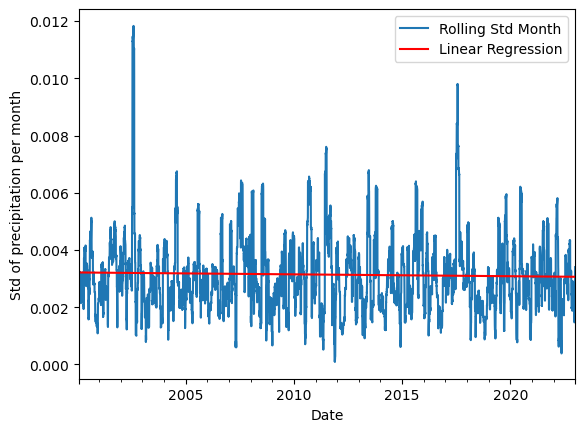

In [96]:
P_sample_clean = P_sample.dropna(subset=['rolling_std_month'])

# Fit a linear regression line
x = np.array(range(len(P_sample_clean.index)))
y = P_sample_clean['rolling_std_month'].values
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

# Plot the data and the regression line
P_sample_clean['rolling_std_month'].plot(label='Rolling Std Month')
plt.plot(P_sample_clean.index, polynomial(x), color='red', label='Linear Regression')
plt.xlabel('Date')
plt.ylabel('Std of precipitation per month')
plt.legend()
plt.show()

In [132]:
trends_df = {
    'lat': [],
    'lon': [],
    'trend_coef': [],
    'trend_p_value': [] 
}

for (lat, lon), P_sample in P_data.groupby(['lat', 'lon']):
    P_sample['rolling_std_year'] = P_sample['tp'].rolling(window=365).std()

    # Fit a linear model
    P_sample = P_sample.dropna(subset=['rolling_std_year'])
    x = np.array(range(len(P_sample.index)))
    X = sm.add_constant(x)
    y = P_sample['rolling_std_year'].values
    model = sm.OLS(y, X).fit()

    trends_df['lat'].append(lat)
    trends_df['lon'].append(lon)
    trends_df['trend_coef'].append(model.params[1])
    trends_df['trend_p_value'].append(model.pvalues[1])


In [133]:
# Iteriere über die Werte im Dictionary
for key, value in trends_df.items():
    # Überprüfe, ob der Schlüssel 'trend_p_value' ist und ob der Wert größer als 0.05 ist
    if key == 'trend_p_value':
        for i, val in enumerate(value):
            if val > 0.05:
                # Setze NA-Wert in 'trend_coefficient' ein
                trends_df['trend_coef'][i] = np.nan


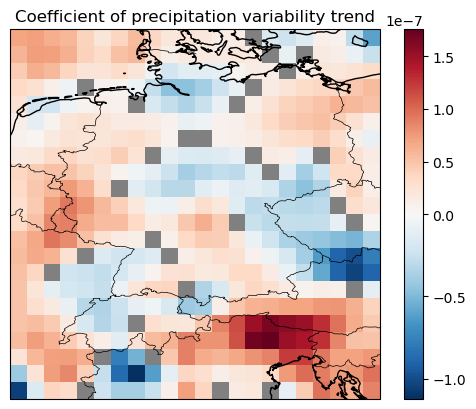

In [139]:
# Create a DataArray with latitude, longitude, and the value
data_array = xr.DataArray(np.reshape(list(trends_df['trend_coef']),(len(np.unique(trends_df['lon'])), len(np.unique(trends_df['lat'])))),
                          coords={'lat': np.unique(trends_df['lat']), 'lon': np.unique(trends_df['lon'])},
                          dims=['lat', 'lon'])

# Create a figure and a set of subplots
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.coastlines()

# Define color map
cmap = plt.cm.RdBu_r
cmap.set_bad(color='gray')

# Plot the data
norm = TwoSlopeNorm(vmin=data_array.min(), vcenter=0, vmax=data_array.max())
data_array.plot.imshow(x='lon', y='lat', norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), ax=ax)

plt.title('Coefficient of precipitation variability trend')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

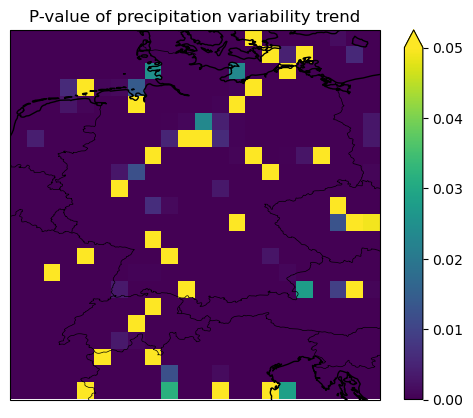

In [125]:
# Create a DataArray with latitude, longitude, and the value
data_array = xr.DataArray(np.reshape(list(trends_df['trend_p_value']),(len(np.unique(trends_df['lon'])), len(np.unique(trends_df['lat'])))),
                          coords={'lat': np.unique(trends_df['lat']), 'lon': np.unique(trends_df['lon'])},
                          dims=['lat', 'lon'])

# Create a figure and a set of subplots
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.coastlines()


# Plot the data
data_array.plot.imshow(x='lon', y='lat', cmap='viridis', transform=ccrs.PlateCarree(), ax=ax, vmax=0.05)

plt.title('P-value of precipitation variability trend')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [43]:
max_trend_data.index

Index([ 176587,  177071,  177555,  178039,  178523,  179007,  179491,  179975,
        180459,  180943,
       ...
       1940283, 1940767, 1941251, 1941735, 1942219, 1942703, 1943187, 1943671,
       1944155, 1944639],
      dtype='int64', length=8037)

/Users/johanna/Uni/applied_land_surface_modelling/env/lib/python3.11/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
/Users/johanna/Uni/applied_land_surface_modelling/env/lib/python3.11/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
/var/folders/f8/v13bbmv53_z7q9w1_d8cgy780000gn/T/ipykernel_47041/2316632502.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

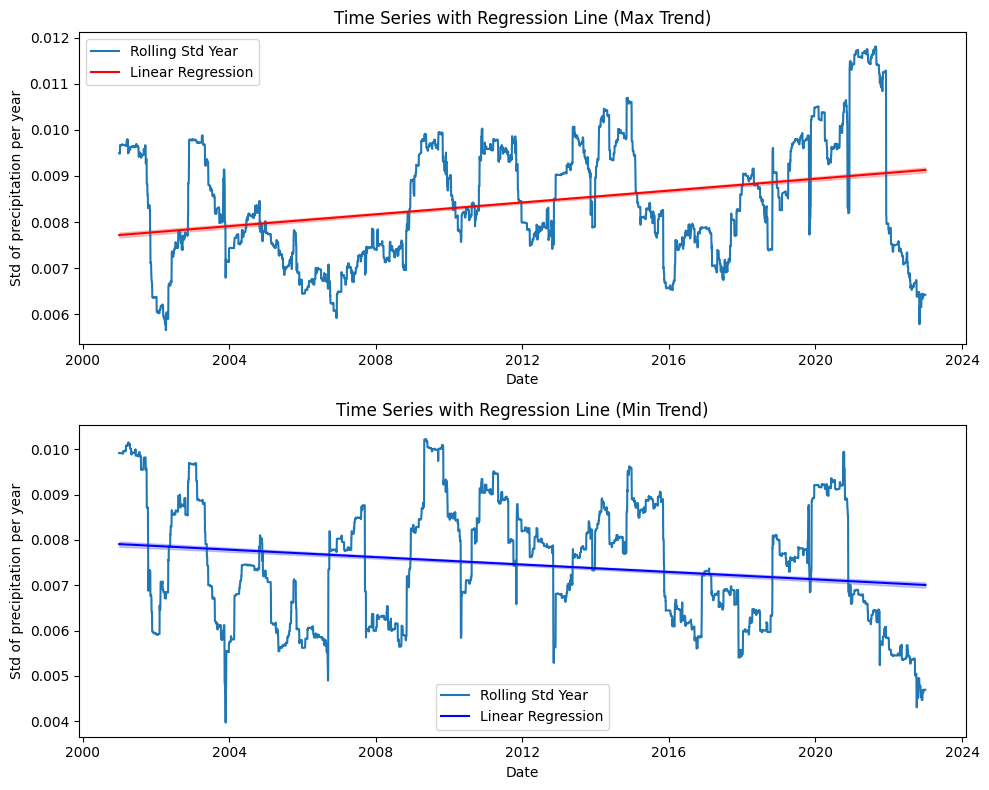

In [46]:
trends_pdf = pd.DataFrame(trends_df)
# Get the index of the maximum and minimum trend_coef values
max_idx = trends_pdf['trend_coef'].idxmax()
min_idx = trends_pdf['trend_coef'].idxmin()

# Extract latitude and longitude for maximum and minimum trend_coef
lat_max = trends_pdf.loc[max_idx, 'lat']
lon_max = trends_pdf.loc[max_idx, 'lon']
lat_min = trends_pdf.loc[min_idx, 'lat']
lon_min = trends_pdf.loc[min_idx, 'lon']

max_trend_data = P_data[(P_data['lat'] == lat_max) & (P_data['lon'] == lon_max)]
min_trend_data = P_data[(P_data['lat'] == lat_min) & (P_data['lon'] == lon_min)]

max_trend_data.loc[:, 'date'] = pd.to_datetime(max_trend_data['date'])
max_trend_data.set_index('date', inplace=True)

min_trend_data.loc[:, 'date'] = pd.to_datetime(min_trend_data['date'])
min_trend_data.set_index('date', inplace=True)

max_trend_data.loc[:, 'rolling_std_year'] = max_trend_data['tp'].rolling(window=365).std()
min_trend_data.loc[:, 'rolling_std_year'] = min_trend_data['tp'].rolling(window=365).std()

# Fit a linear model for max_trend_data
max_trend_data = max_trend_data.dropna(subset=['rolling_std_year'])
x_max = np.array(range(len(max_trend_data.index)))
X_max = sm.add_constant(x_max)
y_max = max_trend_data['rolling_std_year'].values
model_max_trend = sm.OLS(y_max, X_max).fit()

# Fit a linear model for min_trend_data
min_trend_data = min_trend_data.dropna(subset=['rolling_std_year'])
x_min = np.array(range(len(min_trend_data.index)))
X_min = sm.add_constant(x_min)
y_min = min_trend_data['rolling_std_year'].values
model_min_trend = sm.OLS(y_min, X_min).fit()

# Plot the time series with regression line for both max and min trends
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot for max trend
axes[0].plot(max_trend_data.index, max_trend_data['rolling_std_year'], label='Rolling Std Year')
axes[0].plot(max_trend_data.index, model_max_trend.predict(X_max), color='red', label='Linear Regression')
axes[0].fill_between(max_trend_data.index, 
                     model_max_trend.get_prediction(X_max).conf_int()[:, 0], 
                     model_max_trend.get_prediction(X_max).conf_int()[:, 1], color='red', alpha=0.2)
axes[0].set_title('Time Series with Regression Line (Max Trend)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Std of precipitation per year')
axes[0].legend()

# Plot for min trend
axes[1].plot(min_trend_data.index, min_trend_data['rolling_std_year'], label='Rolling Std Year')
axes[1].plot(min_trend_data.index, model_min_trend.predict(X_min), color='blue', label='Linear Regression')
axes[1].fill_between(min_trend_data.index, 
                     model_min_trend.get_prediction(X_min).conf_int()[:, 0], 
                     model_min_trend.get_prediction(X_min).conf_int()[:, 1], color='blue', alpha=0.2)
axes[1].set_title('Time Series with Regression Line (Min Trend)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Std of precipitation per year')
axes[1].legend()

plt.tight_layout()
plt.show()
